In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from mmdet.core.visualization import imshow_det_bboxes
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost, get_distmap, get_distmap_bg
import matplotlib.pyplot as plt
%matplotlib inline

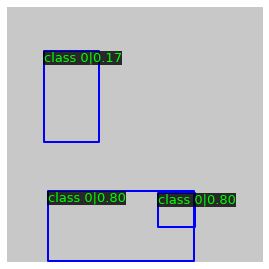

In [3]:
def get_random_bboxes(n, width, height, w_score=True):
    rng = np.random.default_rng()
    bboxes = []
    for _ in range(n):
        x = rng.integers(int(width*0.1), int(width * 0.9))
        y = rng.integers(int(height*0.1), int(height * 0.9))
        dx = rng.integers(int(width*0.1), width - x)
        dy = rng.integers(int(height*0.1), height - y)
        bboxes.append([x, y, x+dx, y+dy])
    if w_score:
        score = np.sort(rng.random(n))[::-1]
        return np.hstack([np.asarray(bboxes), score[:, None]])
    else:
        return np.asarray(bboxes)

im = np.ones((255, 255, 3), dtype=np.uint8)
im *= 200
h, w, _ = im.shape
bboxes=get_random_bboxes(3, w, h)
labels=np.asarray(np.zeros((3), dtype=np.uint8))
o_img = imshow_det_bboxes(im, bboxes, labels, bbox_color="blue")

(-0.5, 1499.5, 254.5, -0.5)

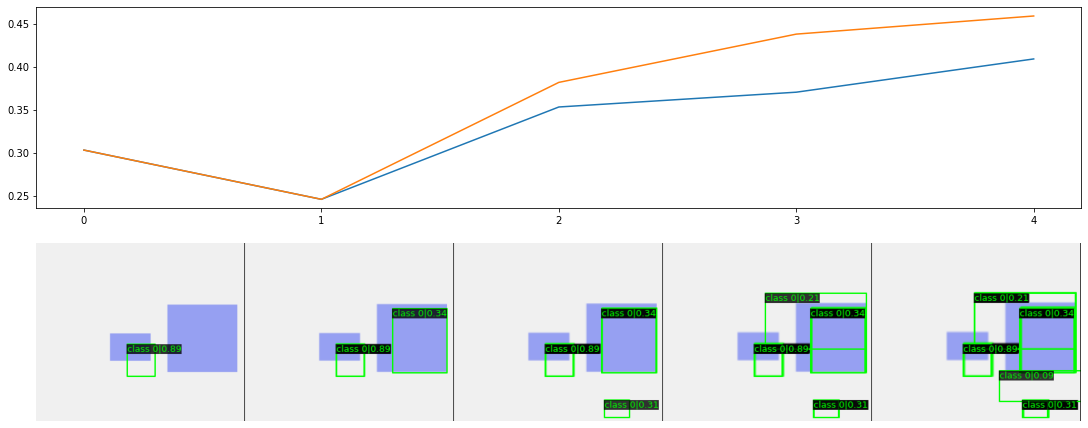

In [6]:
import matplotlib.gridspec as gridspec

img = np.ones((255, 300, 3), dtype=np.uint8) * 240
h, w = img.shape[:2]
gt_bboxes = get_random_bboxes(2, w, h)
gt_bboxes[:, -1] = 1
gt_bboxes = gt_bboxes
rng = np.random.default_rng()
bboxes = gt_bboxes[:,:4] + rng.integers(0, min(h, w)*0.1, (len(gt_bboxes), 4))
red_bboxes = get_random_bboxes(3, w, h, w_score=False)
bboxes = np.vstack([bboxes, red_bboxes])
score = np.sort(rng.random(len(bboxes)))[::-1]
bboxes = np.hstack([np.asarray(bboxes), score[:, None]])
# bboxes = rng.permutation(bboxes)

gt_color = np.asarray([61, 80, 245], dtype=np.uint8)
for x1, y1, x2, y2, _ in gt_bboxes:
    x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
    img[y1:y2, x1:x2, :] = 0.5 * img[y1:y2, x1:x2, :] + 0.5 * gt_color

imgs = []
otcs = []
otcs_d = []
for i in range(len(bboxes)):
    labels = np.zeros((i+1,), dtype=np.int64)
    img = imshow_det_bboxes(img, bboxes[:i+1], labels = labels, bbox_color="green", show=False)
    img[:, -1, :] = 0
    imgs.append(img)
    otc = get_ot_cost([gt_bboxes], [bboxes[:i+1]], get_distmap)
    otcs.append(otc)
    otc = get_ot_cost([gt_bboxes], [bboxes[:i+1]], get_distmap_bg)
    otcs_d.append(otc)

fig = plt.figure(constrained_layout=True, figsize=(15, 6))
spec = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
cost_axes = []
cost_ax = fig.add_subplot(spec[:2, :])   
for otcs_i, label in zip([otcs, otcs_d], ["base", "w_dummy"]):
    cost_ax.plot(np.arange(len(otcs_i)), otcs_i, label=label)
    cost_ax.set_xticks(range(len(imgs)))
    cost_ax.set_xticklabels(range(len(imgs)))
    # cost_ax.set_ylim(0.1, 0.6)
    # cost_axes.append(cost_ax)
cost_ax.legend()
im_ax = fig.add_subplot(spec[2:, :])
im_ax.imshow(np.hstack(imgs))
im_ax.axis("off")